# <center> ${\text{Data 606 Capstone Project: Manufacturing}}$

#### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
# Regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN

np.random.seed(12)
tf.random.set_seed(12)
import warnings

warnings.filterwarnings('ignore')

#### Import files

In [4]:
train02 = pd.read_csv('01_M02_DC_train.csv')
ttf = pd.read_csv('01_M02_DC_train_ttf.csv')
fault = pd.read_csv('01_M02_train_fault_data.csv')

Rename data columns in TTF and view data. 

In [5]:
ttf = ttf.rename({'TTF_FlowCool Pressure Dropped Below Limit':'Flowcool_Pressure_dropped_below_limit'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool Pressure Too High Check Flowcool Pump':'Flowcool_Pressure_Too_High'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool leak':'TTF_Flowcool_leak'}, axis='columns')

In [6]:
train02.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-1.751661,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-1.747158,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-1.747158,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785


In [7]:
ttf.head()

,time,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


#### Merge the data. 

In [8]:
alldata = pd.merge(train02, ttf, how='outer', on='time')

#### Create new features 

Create new features for the four different scenarios used in classification for Fault 1 - Flowcool Pressure Dropped Below Limit. Below are the lower limits the uppper limits define later. 

In [10]:
numlimit1 = 600
numlimit2 = 2400
numlimit3 = 3600
numlimit4 = 20000

In [11]:
alldata['fault1_a'] = alldata['Flowcool_Pressure_dropped_below_limit'].apply(lambda x:1 if x <= numlimit1 else 0)
alldata['fault1_b'] = alldata['Flowcool_Pressure_dropped_below_limit'].apply(lambda x:1 if x <= numlimit2 else 0)
alldata['fault1_c'] = alldata['Flowcool_Pressure_dropped_below_limit'].apply(lambda x:1 if x <= numlimit3 else 0)
alldata['fault1_d'] = alldata['Flowcool_Pressure_dropped_below_limit'].apply(lambda x:1 if x <= numlimit3 else 0)

In [12]:
alldata.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak,fault1_a,fault1_b,fault1_c,fault1_d
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,2.871511,3.175941,4.037785,623234.0,9146470.0,632514.0,0,0,0,0
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,2.871511,3.175941,4.037785,623230.0,9146466.0,632510.0,0,0,0,0
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,2.871511,3.175941,4.037785,623226.0,9146462.0,632506.0,0,0,0,0
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,2.871511,3.175941,4.037785,623222.0,9146458.0,632502.0,0,0,0,0
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,2.871511,3.175941,4.037785,623218.0,9146454.0,632498.0,0,0,0,0


## Regression

#### Drop some of the columns

In [13]:
f1_data = alldata.drop(['time','Lot','Tool','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_Too_High', 'TTF_Flowcool_leak',
                       'fault1_a','fault1_b','fault1_c','fault1_d'], axis=1)
f2_data = alldata.drop(['time','Lot','Tool','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                       'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit',
                        'TTF_Flowcool_leak','fault1_a','fault1_b','fault1_c','fault1_d'], axis=1)
f3_data = alldata.drop(['time','Lot','Tool','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                       'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit',
                        'Flowcool_Pressure_Too_High','fault1_a','fault1_b','fault1_c','fault1_d'], axis=1)

In [14]:
f1data = f1_data.dropna()
f2data = f2_data.dropna()
f3data = f3_data.dropna()

#### Slice the data 

<AxesSubplot:>

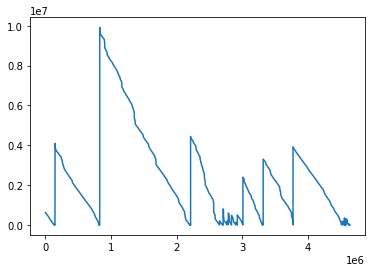

In [15]:
f1_data['Flowcool_Pressure_dropped_below_limit'].plot()

In [16]:
f1_data = f1data.iloc[3010000:4513684]

<AxesSubplot:>

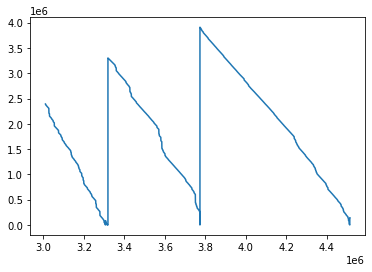

In [17]:
f1_data['Flowcool_Pressure_dropped_below_limit'].plot()

In [18]:
f1_data.shape

(1503684, 14)

In [19]:
train = f1data.loc[3260000:3307064] 

train_drop = train.drop('Flowcool_Pressure_dropped_below_limit', axis=1)

In [15]:
test = f1data.loc[4492500:4513684]

In [17]:
validation2= f1data.loc[2187500:2198597]

In [18]:
print(validation2.shape)

(13901, 14) (11098, 14)


In [14]:
print(train.shape, test.shape)

(47065, 15) (21185, 15)


<AxesSubplot:>

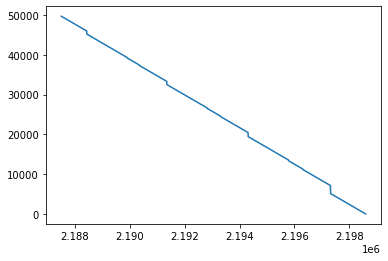

In [45]:
validation2['Flowcool_Pressure_dropped_below_limit'].plot()

<AxesSubplot:>

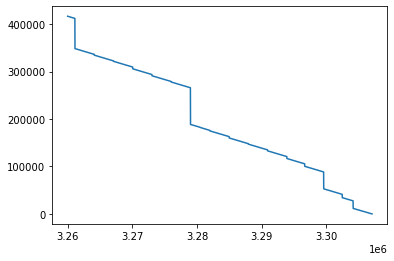

In [46]:
train['Flowcool_Pressure_dropped_below_limit'].plot()

<AxesSubplot:>

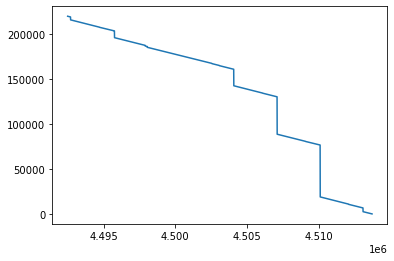

In [47]:
test['Flowcool_Pressure_dropped_below_limit'].plot()

#### Scale the data

In [49]:
scaler = StandardScaler()
scaler = scaler.fit(train)

sstrain = scaler.transform(train)
sstest = scaler.transform(test)
ssval = scaler.transform(validation2)

#### Define x and y variable

In [51]:
trainX, trainy = sstrain[:,:-1],sstrain[:,-1]
testX, testy =  sstest[:,:-1],sstest[:,-1]
valX, valy = ssval[:,:-1],ssval[:,-1]

In [52]:
testX.shape

(21185, 13)

#### Reshape the data

In [54]:
# Reshape
train_X = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
test_X = testX.reshape(testX.shape[0],1,testX.shape[1])
val_X = valX.reshape(valX.shape[0],1,valX.shape[1])

In [57]:
# from tensorlow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
model = Sequential()
model.add(LSTM(50, activation ='relu', input_shape=(1,13), return_sequences=True))
model.add(LSTM(50, activation ='relu', return_sequences = False))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss ='mse', metrics=['RootMeanSquaredError'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             12800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 33,051
Trainable params: 33,051
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(train_X, trainy, epochs=15, batch_size =16, validation_data =(val_X, valy), verbose =1, shuffle=False)

Epoch 1/15
2942/2942 [==============================] - 13s 3ms/step - loss: 0.3608 - root_mean_squared_error: 0.5096 - val_loss: 628.1221 - val_root_mean_squared_error: 25.0624
Epoch 2/15
2942/2942 [==============================] - 9s 3ms/step - loss: 0.2193 - root_mean_squared_error: 0.3607 - val_loss: 25696.4902 - val_root_mean_squared_error: 160.3013
Epoch 3/15
2942/2942 [==============================] - 9s 3ms/step - loss: 0.0647 - root_mean_squared_error: 0.2255 - val_loss: 5190.4658 - val_root_mean_squared_error: 72.0449
Epoch 4/15
2942/2942 [==============================] - 9s 3ms/step - loss: 0.0232 - root_mean_squared_error: 0.1395 - val_loss: 641.0798 - val_root_mean_squared_error: 25.3196
Epoch 5/15
2942/2942 [==============================] - 10s 3ms/step - loss: 0.0314 - root_mean_squared_error: 0.1570 - val_loss: 15.8872 - val_root_mean_squared_error: 3.9859
Epoch 6/15
2942/2942 [==============================] - 9s 3ms/step - loss: 0.0252 - root_mean_squared_error: 0

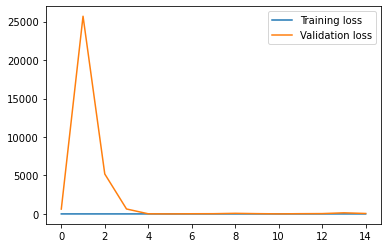

In [60]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [61]:
score, acc = model.evaluate(test_X, testy)
print('score %.2f'%score)
print('score %.2f'%acc)

663/663 [==============================] - 1s 2ms/step - loss: 2260.1655 - root_mean_squared_error: 47.5412
score 2260.17
score 47.54


In [65]:
train_X1 = train_X.reshape(trainX.shape[0],trainX.shape[1])

In [38]:
test_X.shape

(21178, 1, 13)

In [69]:
model1 = Sequential()
model1.add(LSTM(50, activation ='relu', input_shape=(1,13), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(50, activation ='relu', return_sequences = False))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss ='mse', metrics=['MeanSquaredError'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             12800     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 33,051
Trainable params: 33,051
Non-trainable params: 0
_________________________________________________________________


In [70]:
history1 = model1.fit(train_X, trainy, epochs=20, batch_size =16, validation_data =(val_X, valy), verbose =1, shuffle=False)

Epoch 1/20
2942/2942 [==============================] - 10s 3ms/step - loss: 0.4054 - mean_squared_error: 0.4054 - val_loss: 813.8555 - val_mean_squared_error: 813.8555
Epoch 2/20
2942/2942 [==============================] - 7s 3ms/step - loss: 0.3527 - mean_squared_error: 0.3527 - val_loss: 274.3075 - val_mean_squared_error: 274.3075
Epoch 3/20
2942/2942 [==============================] - 7s 2ms/step - loss: 0.1008 - mean_squared_error: 0.1008 - val_loss: 2.5373 - val_mean_squared_error: 2.5373
Epoch 4/20
2942/2942 [==============================] - 7s 2ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 41.9417 - val_mean_squared_error: 41.9417
Epoch 5/20
2942/2942 [==============================] - 7s 2ms/step - loss: 0.0849 - mean_squared_error: 0.0849 - val_loss: 184.4926 - val_mean_squared_error: 184.4926
Epoch 6/20
2942/2942 [==============================] - 7s 2ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 1.3552 - val_mean_squared_error: 1.3552me

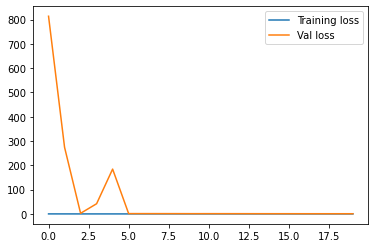

In [71]:
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [72]:
score, acc, = model1.evaluate(test_X, testy)
print('score %.2f'%score)
print('score %.2f'%acc)

663/663 [==============================] - 1s 1ms/step - loss: 0.3909 - mean_squared_error: 0.3909
score 0.39
score 0.39


#### Random Forest Regression

In [96]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

In [97]:
rfr.fit(trainX, trainy)

RandomForestRegressor()

In [98]:
kr_rfr = rfr.predict(testX)

In [99]:
from sklearn.metrics import mean_squared_error

rfr_mse = mean_squared_error(testy, kr_rfr)
rfr_rmse = np.sqrt(rfr_mse)

print(rfr_mse)
print(rfr_rmse)

1.6172442519832677
1.2717091853027043


In [101]:
result = permutation_importance(rfr, testX, testy, random_state=42)

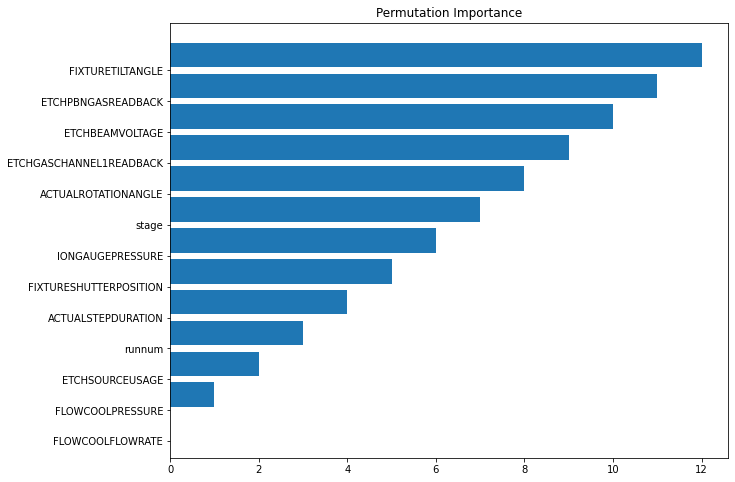

In [102]:
pp = result.importances_mean.argsort()

sort_pp = np.argsort(pp)

pos = np.arange(sort_pp.shape[0])+0.5
y_ticks = np.arange(0,len(train_drop.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, pp[sort_pp])
plt.yticks(y_ticks, train_drop.columns[sort_pp])
plt.title('Permutation Importance')
plt.show()

#### Linear Regression

In [88]:
lr = LinearRegression()

In [89]:
lr.fit(trainX, trainy)

LinearRegression()

In [90]:
kr_lr = lr.predict(testX)

In [91]:
lr_mse = mean_squared_error(testy, kr_lr)
lr_rmse = np.sqrt(lr_mse)

print(lr_mse)
print(lr_rmse)

4361.950330637968
66.04506287859803


#### Ridge

In [92]:
ridge = Ridge()

In [93]:
ridge.fit(trainX, trainy)

Ridge()

In [94]:
kr_ridge = ridge.predict(testX)

In [95]:
ridge_mse = mean_squared_error(testy, kr_ridge)
ridge_rmse = np.sqrt(ridge_mse)

print(ridge_mse)
print(ridge_rmse)

4354.829953741316
65.99113541788257


#### Lasso

In [94]:
lasso = Lasso()

In [95]:
lasso.fit(trainX, trainy)

Lasso()

In [96]:
kr_lasso = lasso.predict(testX)

In [97]:
lasso_mse = mean_squared_error(testy, kr_lasso)
lasso_rmse = np.sqrt(lasso_mse)

print(lasso_mse)
print(lasso_rmse)

0.637131412106502
0.7982051190680889


#### Cross Validation

Cross Validation for the all the models except LSTM which has the validation built into the model.

In [51]:
rfr_valscore = cross_val_score(rfr, valX, valy, scoring='neg_mean_squared_error', cv=5)

rfr_rmse_valscore = np.sqrt(-rfr_valscore)

print('Scores', rfr_rmse_valscore)
print('Mean Score', rfr_rmse_valscore.mean())
print('Standard Deviation', rfr_rmse_valscore.std())

Scores [0.04805749 0.01866792 0.02250445 0.02094705 0.05938306]
Mean Score 0.033911993383302336
Standard Deviation 0.016610079790883425


In [52]:
lr_valscore = cross_val_score(lr, valX, valy, scoring='neg_mean_squared_error', cv=5)

lr_rmse_valscore = np.sqrt(-lr_valscore)

print('Scores', lr_rmse_valscore)
print('Mean Score', lr_rmse_valscore.mean())
print('Standard Deviation', lr_rmse_valscore.std())

Scores [0.00647832 0.00216558 0.00425534 0.00351293 0.00811931]
Mean Score 0.004906295537181199
Standard Deviation 0.0021293879585091084


In [53]:
ridge_valscore = cross_val_score(ridge, valX, valy, scoring='neg_mean_squared_error', cv=5)

ridge_rmse_valscore = np.sqrt(-ridge_valscore)

print('Scores', ridge_rmse_valscore)
print('Mean Score', ridge_rmse_valscore.mean())
print('Standard Deviation', ridge_rmse_valscore.std())

Scores [0.00509183 0.00206414 0.00331106 0.00324793 0.0091468 ]
Mean Score 0.004572352557798861
Standard Deviation 0.0024832011327137688


In [54]:
lasso_valscore = cross_val_score(lasso, valX, valy, scoring='neg_mean_squared_error', cv=5)

lasso_rmse_valscore = np.sqrt(-lasso_valscore)

print('Scores', lasso_rmse_valscore)
print('Mean Score', lasso_rmse_valscore.mean())
print('Standard Deviation', lasso_rmse_valscore.std())

Scores [0.20850031 0.10798215 0.02263817 0.10610784 0.21291228]
Mean Score 0.13162814993833657
Standard Deviation 0.07156210615144025


## Classification

- For each scenario the upper limit is define for Fault 1 - Flowcool Pressure Dropped Below Limit.
- The Random Forest, Gradient Boosting Classifier and the Logistic Regression are run. 
- The models for each scenario are compared. 
- SMOTEENN for the Logistic Regression Scenario 1.

###  Scenario 1: Limit is 10800 and isfailure is 600 - 3 hours, 10 minutes

In [13]:
cl_f1a_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_Too_High', 'TTF_Flowcool_leak',
                       'fault1_b', 'fault1_c','fault1_d'], axis=1)

In [14]:
clf1data = cl_f1a_data.dropna()

Upper limit is at 10800 seconds.

In [15]:
cutoff_1a = 10800

a1_limit = clf1data.loc[3010000:4513684]

cl_cutoff1a = a1_limit.loc[a1_limit['Flowcool_Pressure_dropped_below_limit']<cutoff_1a].copy()

In [16]:
cl_X1a = cl_cutoff1a.drop(['Flowcool_Pressure_dropped_below_limit', 'fault1_a'], axis=1)
cl_Y1a = cl_cutoff1a['fault1_a']

In [17]:
a1_limit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503684 entries, 3010000 to 4513684
Data columns (total 14 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   runnum                                 1503684 non-null  int64  
 1   IONGAUGEPRESSURE                       1503684 non-null  float64
 2   ETCHBEAMVOLTAGE                        1503684 non-null  float64
 3   FLOWCOOLFLOWRATE                       1503684 non-null  float64
 4   FLOWCOOLPRESSURE                       1503684 non-null  float64
 5   ETCHGASCHANNEL1READBACK                1503684 non-null  float64
 6   ETCHPBNGASREADBACK                     1503684 non-null  float64
 7   FIXTURETILTANGLE                       1503684 non-null  float64
 8   ACTUALROTATIONANGLE                    1503684 non-null  float64
 9   FIXTURESHUTTERPOSITION                 1503684 non-null  float64
 10  ETCHSOURCEUSAGE                     

In [18]:
cl_X1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
3304346,12094607,-0.027025,1.545122,0.569103,0.115018,-1.184954,0.363231,-0.980728,-0.122455,1.0,0.701167,-0.657107
3304347,12094607,-0.027025,1.546048,0.569103,0.115018,-1.192961,0.363231,-0.980728,-0.122455,1.0,0.701170,-0.657107
3304348,12094607,-0.027025,1.545288,0.563367,0.115018,-1.191460,0.365508,-0.980728,-0.122455,1.0,0.701173,-0.657107
3304349,12094607,-0.024296,1.545122,0.563367,0.117588,-1.184954,0.365508,-0.980728,-0.122455,1.0,0.701177,-0.657107
3304350,12094607,-0.024296,1.545407,0.563367,0.117588,-1.192961,0.362004,-0.980728,-0.122455,1.0,0.701180,-0.657107


In [19]:
cl_Y1a.value_counts()

0    9582
1     601
Name: fault1_a, dtype: int64

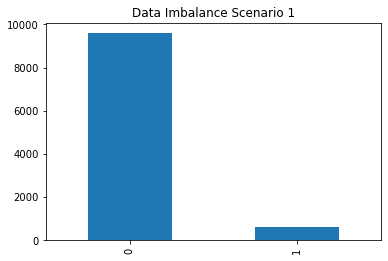

In [20]:
cl_Y1a.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 1")
plt.xticks()
plt.show()

In [21]:
X_train1a, X_test1a, Y_train1a, Y_test1a = train_test_split(cl_X1a, cl_Y1a, test_size = 0.2, random_state=42)

In [22]:
X_train1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
3313631,12100490,0.017439,0.710387,-0.248717,-0.200626,1.408630,0.364281,-1.315014,-0.122455,1.0,0.729285,0.021044
3318008,12100490,-0.079552,-0.958985,-2.842907,-2.332807,-1.748909,-2.791223,2.027848,-0.122446,0.0,0.736737,6.280900
3318780,12100490,-0.079559,-0.958928,-2.840944,-2.332807,-1.756665,-2.793501,2.027848,-0.122446,0.0,0.736737,6.280900
3317591,12100490,-0.079544,-0.958985,-2.841850,-2.332807,-1.748909,-2.788945,0.022131,0.182382,0.0,0.736737,6.280900
3315180,12100490,-0.079551,-0.958871,-2.841850,-2.332807,-1.750410,-2.792450,0.022131,6.393209,0.0,0.731627,0.803526


In [23]:
cl_scalar = MinMaxScaler()
cl_scalar.fit(X_train1a)

scl_trainX1a = cl_scalar.transform(X_train1a)
scl_testX1a = cl_scalar.transform(X_test1a)

#### Random Forest Classifier A

In [24]:
rfc_a = RandomForestClassifier(random_state=42)

rfc_a.fit(scl_trainX1a, Y_train1a)

RandomForestClassifier(random_state=42)

In [25]:
rfc_pred_a = rfc_a.predict(scl_testX1a)

rfc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('AccuracyScoreRandom Forest Scenario 1:{:.3f}\n'.format(rfc_accuracy_a))
print('Classification Report Random Forest Scenario 1\n\n',classification_report(Y_test1a, rfc_pred_a))

AccuracyScoreRandom Forest Scenario 1:0.984

Classification Report Random Forest Scenario 1

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1910
           1       0.94      0.80      0.86       127

    accuracy                           0.98      2037
   macro avg       0.97      0.90      0.93      2037
weighted avg       0.98      0.98      0.98      2037



In [26]:
rfc_cm = confusion_matrix(Y_test1a, rfc_pred_a)

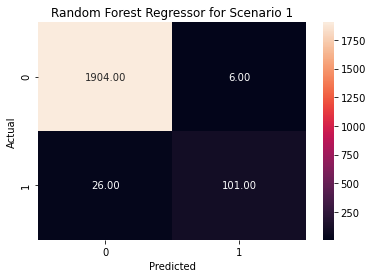

In [27]:
sns.heatmap(rfc_cm, annot=True, fmt='.2f')
plt.title('Random Forest Regressor for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier  A

In [28]:
gbc_a = GradientBoostingClassifier(random_state=42)

gbc_a.fit(scl_trainX1a, Y_train1a)

GradientBoostingClassifier(random_state=42)

In [29]:
gbc_pred_a = gbc_a.predict(scl_testX1a)

gbc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('Accuracy Score Gradient Boost Classifier Scenario 1:{:.3f}\n'.format(gbc_accuracy_a))
print('Classification Report Gradient Boost Classifier Scenario 1\n\n', classification_report(Y_test1a, gbc_pred_a))

Accuracy Score Gradient Boost Classifier Scenario 1:0.984

Classification Report Gradient Boost Classifier Scenario 1

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1910
           1       0.99      0.71      0.83       127

    accuracy                           0.98      2037
   macro avg       0.98      0.85      0.91      2037
weighted avg       0.98      0.98      0.98      2037



In [30]:
gbc_cm = confusion_matrix(Y_test1a, gbc_pred_a)

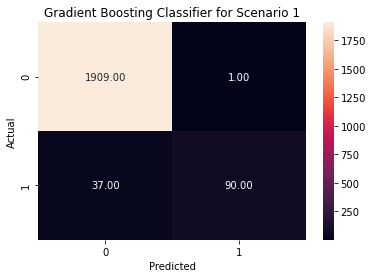

In [31]:
sns.heatmap(gbc_cm, annot=True, fmt='.2f')
plt.title('Gradient Boosting Classifier for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression A

In [32]:
logreg_a = LogisticRegression(random_state=7)

logreg_a.fit(scl_trainX1a, Y_train1a)

LogisticRegression(random_state=7)

In [33]:
logreg_pred_a = logreg_a.predict(scl_testX1a)

logreg_accuracy_a = accuracy_score(Y_test1a, logreg_pred_a)

print('Accuracy Score Logistic Regression Scenario 1:{:.3f}\n'.format(logreg_accuracy_a))
print('Classification Report Logistic Regression Scenario 1\n\n', classification_report(Y_test1a, logreg_pred_a))

Accuracy Score Logistic Regression Scenario 1:0.939

Classification Report Logistic Regression Scenario 1

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1910
           1       1.00      0.02      0.03       127

    accuracy                           0.94      2037
   macro avg       0.97      0.51      0.50      2037
weighted avg       0.94      0.94      0.91      2037



#### Cross Validation A

In [34]:
rfc_valscore_a = cross_validate(rfc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].std()))

Scores:
 [0.83428571 0.88648649 0.86705202 0.87640449 0.82872928]
Scores:0.859
Scores:0.023


In [35]:
gbc_valscore_a = cross_validate(gbc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].std()))

Score:
 [0.83428571 0.88648649 0.86705202 0.87640449 0.82872928]
Scores:0.865
Scores:0.014


In [36]:
logreg_valscore_a = cross_validate(logreg_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].std()))

Score:
 [0.83428571 0.88648649 0.86705202 0.87640449 0.82872928]
Scores:0.032
Scores:0.034


#### Fine Tune Parameters

#### Fine Tuning the Random Forest Classifier

Different hyperparameters are tried out using GridSearchCV to improve performance.

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
rfc_grid = [{'n_estimators':[50,200], 'max_depth':[5,10], 'criterion':['entropy','gini']}]

rfc_cv = RandomForestClassifier()

In [39]:
rfc_gridsearch= GridSearchCV(estimator =rfc_cv, param_grid=rfc_grid, cv=5, return_train_score=True )

rfc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 10], 'n_estimators': [50, 200]}],
             return_train_score=True)

In [40]:
rfc_gridsearch.best_score_

0.9860055662889273

In [41]:
rfc_best = rfc_gridsearch.best_estimator_

In [42]:
rfc_best_a = rfc_best.predict(scl_testX1a)

rfc_best_accuracy_a = accuracy_score(Y_test1a, rfc_best_a)

print('Accuracy Score Random Forest Best Estimator Scenario 1:{:.3f}\n'.format(rfc_best_accuracy_a))
print('Classification Report Random Forest Best Estimator Scenario 1\n\n', classification_report(Y_test1a, rfc_best_a))

Accuracy Score Random Forest Best Estimator Scenario 1:0.982

Classification Report Random Forest Best Estimator Scenario 1

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1910
           1       1.00      0.71      0.83       127

    accuracy                           0.98      2037
   macro avg       0.99      0.85      0.91      2037
weighted avg       0.98      0.98      0.98      2037



#### Fine Tuning the Gradient Boosting Classifier

In [43]:
gbc_grid = [{'n_estimators':[50,150], 'max_depth':[2,5]}]

gbc_cv = GradientBoostingClassifier()

In [44]:
gbc_gridsearch= GridSearchCV(estimator = gbc_cv, param_grid=gbc_grid, cv=5, return_train_score=True )

gbc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid=[{'max_depth': [2, 5], 'n_estimators': [50, 150]}],
             return_train_score=True)

In [45]:
gbc_gridsearch.best_score_

0.9853916174249701

In [46]:
gbc_best = gbc_gridsearch.best_estimator_

In [47]:
gbc_best_a = gbc_best.predict(scl_testX1a)

gbc_best_accuracy_a = accuracy_score(Y_test1a, gbc_best_a)

print('Accuracy Score Gradient Boosting Best Estimator Scenario 1:{:.3f}\n'.format(gbc_best_accuracy_a))
print('Classification Report Logistic Regression Scenario 1\n\n', classification_report(Y_test1a, gbc_best_a))

Accuracy Score Gradient Boosting Best Estimator Scenario 1:0.980

Classification Report Logistic Regression Scenario 1

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1910
           1       0.98      0.69      0.81       127

    accuracy                           0.98      2037
   macro avg       0.98      0.85      0.90      2037
weighted avg       0.98      0.98      0.98      2037



#### Fine Tuning Logistic Regression

In [48]:
grid = [{'C':[0.01,0.1,1], 'penalty':['l1'],'solver':['liblinear']},
        {'C':[0.01,0.1,1], 'penalty':['l2'],'solver':['lbfgs']}]
         
logreg_cv = LogisticRegression(random_state=7, max_iter=200)

In [49]:
logreg_gridsearch = GridSearchCV(estimator =logreg_cv, param_grid=grid, cv=5, return_train_score=True )

logreg_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=7),
             param_grid=[{'C': [0.01, 0.1, 1], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             return_train_score=True)

In [50]:
logreg_gridsearch.best_score_

0.9450039355696408

In [51]:
logreg_gridsearch.best_estimator_

LogisticRegression(C=1, max_iter=200, penalty='l1', random_state=7,
                   solver='liblinear')

In [52]:
logreg_bestest =logreg_gridsearch.best_estimator_

In [53]:
logreg_best_a = logreg_bestest.predict(scl_testX1a)

logreg_best_accuracy_a = accuracy_score(Y_test1a, logreg_best_a)

print('Accuracy Score Logistic Regression Scenario 1:{:.3f}\n'.format(logreg_best_accuracy_a))
print('Classification Report Logistic Regression Scenario 1\n\n', classification_report(Y_test1a, logreg_best_a))

Accuracy Score Logistic Regression Scenario 1:0.944

Classification Report Logistic Regression Scenario 1

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1910
           1       0.93      0.10      0.18       127

    accuracy                           0.94      2037
   macro avg       0.94      0.55      0.58      2037
weighted avg       0.94      0.94      0.92      2037



In [54]:
logreg_cm = confusion_matrix(Y_test1a, logreg_best_a)

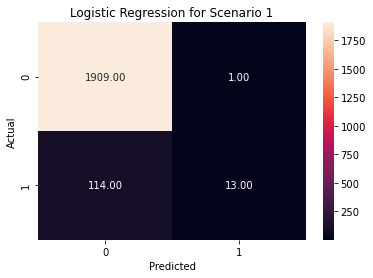

In [55]:
sns.heatmap(logreg_cm, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Scenario 2: Limit is 19800 and failure is 2400 - 5 1/2 hours, 40 minutes

In [56]:
cl_f1b_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_Too_High', 'TTF_Flowcool_leak',
                       'fault1_a', 'fault1_c','fault1_d'], axis=1)

In [57]:
clf1data_b = cl_f1b_data.dropna()

In [58]:
cutoff_1b = 19800

b1_limit = clf1data_b.loc[3010000:4513684]

cl_cutoff1b = b1_limit.loc[b1_limit['Flowcool_Pressure_dropped_below_limit']<cutoff_1b].copy()

In [59]:
cl_X1b = cl_cutoff1b.drop(['Flowcool_Pressure_dropped_below_limit', 'fault1_b'], axis=1)
cl_Y1b = cl_cutoff1b['fault1_b']

In [60]:
cl_X1b.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
3304133,12094607,-0.079521,-0.958758,-2.842907,-2.332807,-1.756665,-2.791223,2.027848,-0.122464,0.0,0.700593,-0.370197
3304134,12094607,-0.079521,-0.958814,-2.842907,-2.332807,-1.756665,-2.791223,2.027848,-0.122464,0.0,0.700593,-0.370197
3304135,12094607,-0.079516,-0.958985,-2.842907,-2.332807,-1.756665,-2.791223,2.027848,-0.122464,0.0,0.700593,-0.370197
3304136,12094607,-0.079516,-0.959042,-2.842907,-2.332807,-1.753413,-2.793501,2.027848,-0.122464,0.0,0.700593,-0.370197
3304137,12094607,-0.079552,-0.959269,-2.842907,-2.332807,-1.753413,-2.793501,2.027848,-0.122464,0.0,0.700593,-0.370197


In [61]:
cl_Y1b.value_counts()

0    10487
1     2661
Name: fault1_b, dtype: int64

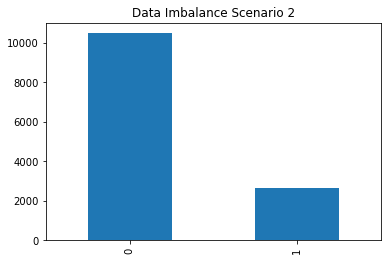

In [75]:
cl_Y1b.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 2")
plt.xticks()
plt.show()

In [73]:
X_train1b, X_test1b, Y_train1b, Y_test1b = train_test_split(cl_X1b, cl_Y1b, test_size = 0.2, random_state=42)

In [64]:
cl_scalar_b = MinMaxScaler()
cl_scalar_b.fit(X_train1b)

scl_trainX1b = cl_scalar.transform(X_train1b)
scl_testX1b = cl_scalar.transform(X_test1b)

#### Random Forest Classifier B

In [78]:
rfc_b = RandomForestClassifier(random_state=42)

rfc_b.fit(scl_trainX1b, Y_train1b)

RandomForestClassifier(random_state=42)

In [79]:
rfc_pred_b = rfc_b.predict(scl_testX1b)

rfc_accuracy_b = accuracy_score(Y_test1b, rfc_pred_b)

print('AccuracyScore Random Forest Scenario 2:{:.3f}\n'.format(rfc_accuracy_b))
print('Classification Report Random Forest Scenario 2\n\n',classification_report(Y_test1b, rfc_pred_b))

AccuracyScore Random Forest Scenario 2:0.987

Classification Report Random Forest Scenario 2

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2087
           1       0.97      0.97      0.97       543

    accuracy                           0.99      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.99      0.99      0.99      2630



In [80]:
rfc_cm_b = confusion_matrix(Y_test1b, rfc_pred_b)

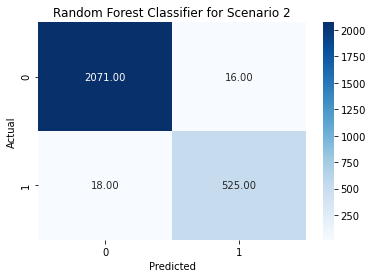

In [81]:
sns.heatmap(rfc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Random Forest Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier B

In [82]:
gbc_b = GradientBoostingClassifier()

gbc_b.fit(scl_trainX1b, Y_train1b)

GradientBoostingClassifier()

In [83]:
gbc_pred_b = gbc_b.predict(scl_testX1b)

gbc_accuracy_b = accuracy_score(Y_test1b, gbc_pred_b)

print('Accuracy Score Gradient Boost Classifier Scenario 2:{:.3f}\n'.format(gbc_accuracy_b))
print('Classification Report Gradient Boost Classifier Scenario 2\n\n', classification_report(Y_test1b, gbc_pred_b))

Accuracy Score Gradient Boost Classifier Scenario 2:0.986

Classification Report Gradient Boost Classifier Scenario 2

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2087
           1       1.00      0.93      0.96       543

    accuracy                           0.99      2630
   macro avg       0.99      0.97      0.98      2630
weighted avg       0.99      0.99      0.99      2630



In [84]:
gbc_cm_b = confusion_matrix(Y_test1b, gbc_pred_b)

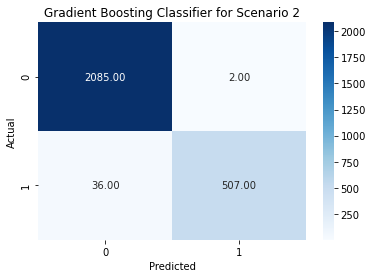

In [85]:
sns.heatmap(gbc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression B

In [86]:
logreg_b = LogisticRegression(random_state=7)

logreg_b.fit(scl_trainX1b, Y_train1b)

LogisticRegression(random_state=7)

In [87]:
logreg_pred_b = logreg_b.predict(scl_testX1b)

logreg_accuracy_b = accuracy_score(Y_test1b, logreg_pred_b)

print('Accuracy Score Logistic Regression Scenario 2: {:.3f}\n'.format(logreg_accuracy_b))
print('Classification Report Logistic Regression Scenario 2\n\n', classification_report(Y_test1b, logreg_pred_b))

Accuracy Score Logistic Regression Scenario 2: 0.836

Classification Report Logistic Regression Scenario 2

               precision    recall  f1-score   support

           0       0.84      0.99      0.91      2087
           1       0.85      0.25      0.39       543

    accuracy                           0.84      2630
   macro avg       0.84      0.62      0.65      2630
weighted avg       0.84      0.84      0.80      2630



In [88]:
logreg_cm_b = confusion_matrix(Y_test1b, logreg_pred_b)

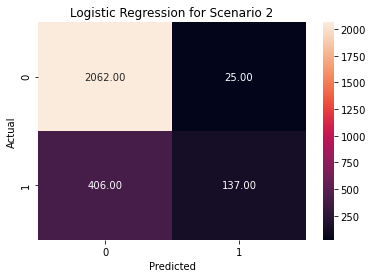

In [89]:
sns.heatmap(logreg_cm_b, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation B

In [90]:
rfc_valscore_b = cross_validate(rfc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].std()))

Scores:0.961
Scores:0.007


In [91]:
gbc_valscore_b = cross_validate(gbc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].std()))

Scores:0.961
Scores:0.005


In [92]:
logreg_valscore_b = cross_validate(logreg_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].std()))

Scores:0.345
Scores:0.019


### Scenario 3: Limit is 28800 and failure is 3600 - 8 hours, 1 hour

In [93]:
cl_f1c_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_Too_High', 'TTF_Flowcool_leak',
                       'fault1_a', 'fault1_b','fault1_d'], axis=1)

In [94]:
clf1data_c = cl_f1c_data.dropna()

In [95]:
cutoff_1c = 28800

c1_limit = clf1data_c.loc[3010000:4513684]

cl_cutoff1c = c1_limit.loc[c1_limit['Flowcool_Pressure_dropped_below_limit']<cutoff_1c].copy()

In [96]:
cl_X1c = cl_cutoff1c.drop(['Flowcool_Pressure_dropped_below_limit', 'fault1_c'], axis=1)
cl_Y1c = cl_cutoff1c['fault1_c']

In [97]:
cl_X1c.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
3303848,12093089,0.00146,1.188129,0.583763,0.228161,-0.060052,0.364281,0.022131,-0.122455,1.0,0.700019,0.803526
3303849,12093089,0.00146,1.189211,0.577996,0.232016,-0.060052,0.364281,0.022131,-0.122455,1.0,0.700022,0.803526
3303850,12093089,0.00146,1.187958,0.577996,0.229446,-0.058299,0.364281,0.022131,-0.122455,1.0,0.700026,0.803526
3303851,12093089,0.00146,1.188129,0.565479,0.230099,-0.058299,0.359727,0.022131,-0.122455,1.0,0.700029,0.803526
3303852,12093089,0.00146,1.188301,0.565479,0.230099,-0.058299,0.359727,0.022131,-0.122455,1.0,0.700032,0.803526


In [98]:
cl_Y1c.value_counts()

0    11781
1     3737
Name: fault1_c, dtype: int64

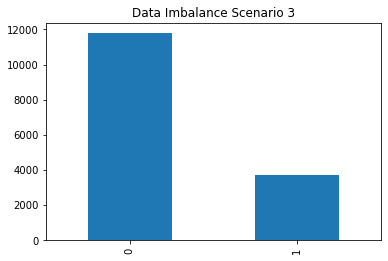

In [102]:
cl_Y1c.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 3")
plt.xticks()
plt.show()

In [103]:
X_train1c, X_test1c, Y_train1c, Y_test1c = train_test_split(cl_X1c, cl_Y1c, test_size = 0.2, random_state=42)

In [104]:
cl_scalar_c = MinMaxScaler()
cl_scalar_c.fit(X_train1c)

scl_trainX1c = cl_scalar.transform(X_train1c)
scl_testX1c = cl_scalar.transform(X_test1c)

#### Random Forest Classifier C

In [105]:
rfc_c = RandomForestClassifier(random_state=42)

rfc_c.fit(scl_trainX1c, Y_train1c)

RandomForestClassifier(random_state=42)

In [106]:
rfc_pred_c = rfc_c.predict(scl_testX1c)

rfc_accuracy_c = accuracy_score(Y_test1c, rfc_pred_c)

print('Accuracy Score Random Forest Classifier Scenario 3: {:.3f}\n'.format(rfc_accuracy_c))
print('Classification Report Random Forest Classifier Scenario 3\n\n',classification_report(Y_test1c, rfc_pred_c))

Accuracy Score Random Forest Classifier Scenario 3: 0.996

Classification Report Random Forest Classifier Scenario 3

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2342
           1       1.00      0.99      0.99       762

    accuracy                           1.00      3104
   macro avg       1.00      0.99      0.99      3104
weighted avg       1.00      1.00      1.00      3104



In [107]:
rfc_cm_c = confusion_matrix(Y_test1c, rfc_pred_c)

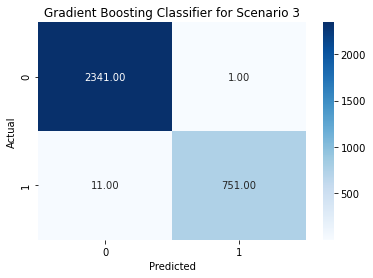

In [108]:
sns.heatmap(rfc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier

In [109]:
cl_result = permutation_importance(rfc_c, scl_testX1c, Y_test1c, random_state=42)

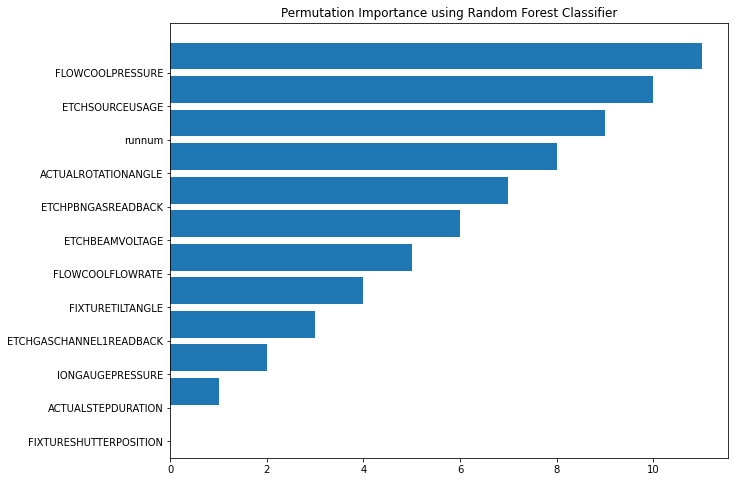

In [110]:
cl_pp = cl_result.importances_mean.argsort()

cl_sort_pp = np.argsort(cl_pp)

pos = np.arange(cl_sort_pp.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1c.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp[cl_sort_pp])
plt.yticks(y_ticks, cl_X1c.columns[cl_sort_pp])
plt.title('Permutation Importance using Random Forest Classifier')
plt.show()

#### Gradient Boost Classifier C

In [111]:
gbc_c = GradientBoostingClassifier(random_state=42)

gbc_c.fit(scl_trainX1c, Y_train1c)

GradientBoostingClassifier(random_state=42)

In [112]:
gbc_pred_c = gbc_c.predict(scl_testX1c)

gbc_accuracy_c = accuracy_score(Y_test1c, gbc_pred_c)

print('Accuracy Score Gradient Boost Classifier Scenario 3: {:.3f}\n'.format(gbc_accuracy_c))
print('Classification Report Gradient Boost Classifier Scenario 3\n\n', classification_report(Y_test1c, gbc_pred_c))

Accuracy Score Gradient Boost Classifier Scenario 3: 0.994

Classification Report Gradient Boost Classifier Scenario 3

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2342
           1       1.00      0.98      0.99       762

    accuracy                           0.99      3104
   macro avg       1.00      0.99      0.99      3104
weighted avg       0.99      0.99      0.99      3104



In [113]:
gbc_cm_c = confusion_matrix(Y_test1c, gbc_pred_c)

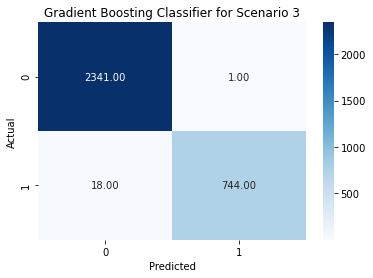

In [114]:
sns.heatmap(gbc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression C

In [115]:
logreg_c = LogisticRegression(random_state=7)

logreg_c.fit(scl_trainX1c, Y_train1c)

LogisticRegression(random_state=7)

In [116]:
logreg_pred_c = logreg_c.predict(scl_testX1c)

logreg_accuracy_c = accuracy_score(Y_test1c, logreg_pred_c)

print('Accuracy Score Logistic Regression Scenario 3: {:.3f}\n'.format(logreg_accuracy_c))
print('Classification Report Logistic Regression Scenario 3\n\n', classification_report(Y_test1c, logreg_pred_c))

Accuracy Score Logistic Regression Scenario 3: 0.835

Classification Report Logistic Regression Scenario 3

               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2342
           1       0.81      0.43      0.56       762

    accuracy                           0.84      3104
   macro avg       0.82      0.70      0.73      3104
weighted avg       0.83      0.84      0.82      3104



In [117]:
logreg_cm_c = confusion_matrix(Y_test1c, logreg_pred_c)

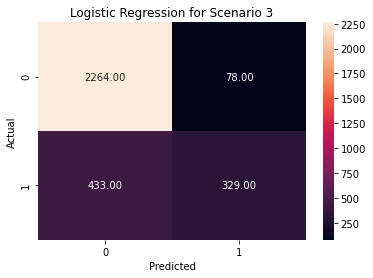

In [118]:
sns.heatmap(logreg_cm_c, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation C

In [119]:
rfc_valscore_c = cross_validate(rfc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_c['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].std()))

Scores:
 [0.99747262 0.99494949 0.99325464 0.98813559 0.99580185]
Scores:0.994
Scores:0.003


In [120]:
gbc_valscore_c = cross_validate(gbc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_c['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].std()))

Scores:
 [0.99323181 0.98983051 0.98899238 0.9872989  0.98901099]
Scores:0.990
Scores:0.002


In [121]:
logreg_valscore_c = cross_validate(logreg_c, scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_c['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].std()))

Scores:
 [0.57612267 0.57579062 0.57540107 0.602537   0.58823529]
Scores:0.584
Scores:0.011


## Scenario 4: 86400 and failure is 20000 - 24 hours, about 51/2 hours

In [122]:
cl_f1d_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_Too_High', 'TTF_Flowcool_leak',
                       'fault1_a', 'fault1_b','fault1_c'], axis=1)

In [123]:
clf1data_d = cl_f1d_data.dropna()

In [124]:
cutoff_1d = 86400

d1_limit = clf1data_d.loc[3010000:4513684]

cl_cutoff1d = d1_limit.loc[d1_limit['Flowcool_Pressure_dropped_below_limit']<cutoff_1d].copy()

In [125]:
cl_X1d = cl_cutoff1d.drop(['Flowcool_Pressure_dropped_below_limit', 'fault1_d'], axis=1)
cl_Y1d = cl_cutoff1d['fault1_d']

In [126]:
cl_X1d.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
3299579,12091675,-0.079438,-0.958928,-2.842907,-2.332807,-1.754914,-2.789997,2.027848,-0.122446,0.0,0.687049,4.037785
3299580,12091675,-0.079438,-0.959099,-2.842907,-2.332807,-1.753413,-2.789997,2.027848,-0.122446,0.0,0.687049,4.037785
3299581,12091675,-0.079427,-0.958871,-2.842907,-2.332807,-1.753413,-2.789997,2.027848,-0.122446,0.0,0.687049,4.037785
3299582,12091675,-0.079418,-0.958701,-2.842907,-2.332807,-1.754914,-2.792450,2.027848,-0.122446,0.0,0.687049,4.037785
3299583,12091675,-0.079440,-0.958985,-2.842907,-2.332807,-1.754914,-2.792450,2.027848,-0.122446,0.0,0.687049,4.037785


In [127]:
cl_Y1d.value_counts()

0    22355
1     3737
Name: fault1_d, dtype: int64

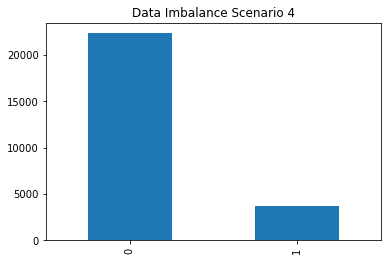

In [129]:
cl_Y1d.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 4")
plt.xticks()
plt.show()

In [130]:
X_train1d, X_test1d, Y_train1d, Y_test1d = train_test_split(cl_X1d, cl_Y1d, test_size = 0.2, random_state=42)

In [131]:
cl_scalar_d = MinMaxScaler()
cl_scalar_d.fit(X_train1d)

scl_trainX1d = cl_scalar.transform(X_train1d)
scl_testX1d = cl_scalar.transform(X_test1d)

#### Random Forest Classifier D

In [132]:
rfc_d = RandomForestClassifier()

rfc_d.fit(scl_trainX1d, Y_train1d)

RandomForestClassifier()

In [133]:
rfc_pred_d = rfc_d.predict(scl_testX1d)

rfc_accuracy_d = accuracy_score(Y_test1d, rfc_pred_d)

print('Accuracy Score Random Forest Classifier Scenario 4: {:.3f}\n'.format(rfc_accuracy_d))
print('Classification Report Random Forest Classifier Scenario 4\n\n',classification_report(Y_test1d, rfc_pred_d))

Accuracy Score Random Forest Classifier Scenario 4: 0.998

Classification Report Random Forest Classifier Scenario 4

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4518
           1       0.99      0.99      0.99       701

    accuracy                           1.00      5219
   macro avg       1.00      1.00      1.00      5219
weighted avg       1.00      1.00      1.00      5219



In [134]:
rfc_cm_d = confusion_matrix(Y_test1d, rfc_pred_d)

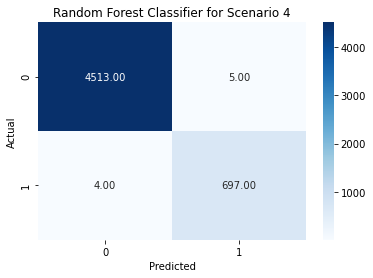

In [135]:
sns.heatmap(rfc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Random Forest Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier D

In [136]:
cl_result_d = permutation_importance(rfc_d, scl_testX1d, Y_test1d, random_state=42)

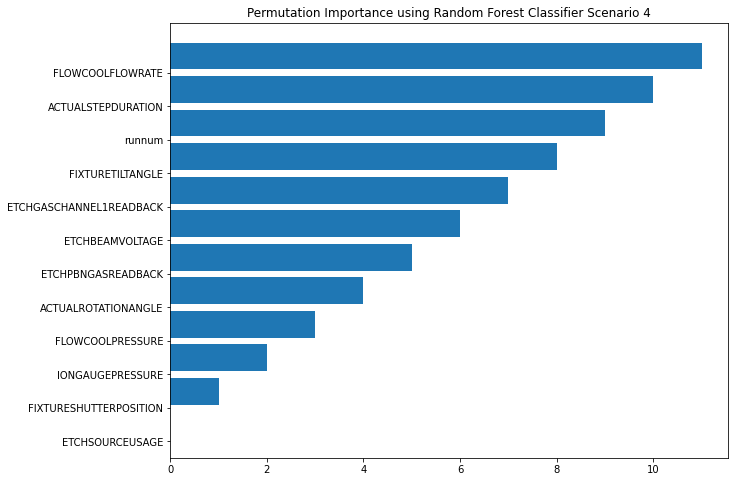

In [137]:
cl_pp_d = cl_result_d.importances_mean.argsort()

cl_sort_pp_d = np.argsort(cl_pp_d)

pos = np.arange(cl_sort_pp_d.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1d.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp_d[cl_sort_pp_d])
plt.yticks(y_ticks, cl_X1d.columns[cl_sort_pp_d])
plt.title('Permutation Importance using Random Forest Classifier Scenario 4')
plt.show()

#### Gradient Boost Classifier D

In [138]:
gbc_d = GradientBoostingClassifier()

gbc_d.fit(scl_trainX1d, Y_train1d)

GradientBoostingClassifier()

In [139]:
gbc_pred_d = gbc_d.predict(scl_testX1d)

gbc_accuracy_d = accuracy_score(Y_test1d, gbc_pred_d)

print('Accuracy Score Gradient Boost Classifier Scenario 4: {:.3f}\n'.format(gbc_accuracy_d))
print('Classification Report Gradient Boost Classifier Scenario 4\n\n', classification_report(Y_test1d, gbc_pred_d))

Accuracy Score Gradient Boost Classifier Scenario 4: 0.997

Classification Report Gradient Boost Classifier Scenario 4

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4518
           1       0.99      0.98      0.99       701

    accuracy                           1.00      5219
   macro avg       1.00      0.99      0.99      5219
weighted avg       1.00      1.00      1.00      5219



In [140]:
gbc_cm_d = confusion_matrix(Y_test1d, gbc_pred_d)

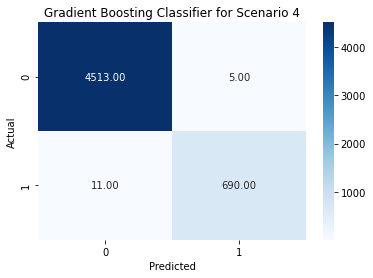

In [141]:
sns.heatmap(gbc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression D

In [142]:
logreg_d = LogisticRegression(random_state=7)

logreg_d.fit(scl_trainX1d, Y_train1d)

LogisticRegression(random_state=7)

In [143]:
logreg_pred_d = logreg_d.predict(scl_testX1d)

logreg_accuracy_d = accuracy_score(Y_test1d, logreg_pred_d)

print('Accuracy Score Logistic Regression Scenario 4: {:.3f}\n'.format(logreg_accuracy_d))
print('Classification Report Logistic Regression Scenario 4\n\n', classification_report(Y_test1d, logreg_pred_d))

Accuracy Score Logistic Regression Scenario 4: 0.910

Classification Report Logistic Regression Scenario 4

               precision    recall  f1-score   support

           0       0.92      0.98      0.95      4518
           1       0.79      0.44      0.57       701

    accuracy                           0.91      5219
   macro avg       0.86      0.71      0.76      5219
weighted avg       0.90      0.91      0.90      5219



In [144]:
logreg_cm_d = confusion_matrix(Y_test1d, logreg_pred_d)

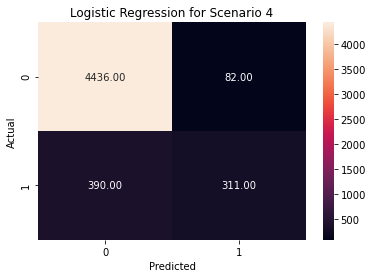

In [146]:
sns.heatmap(logreg_cm_d, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation D

In [147]:
rfc_valscore_d = cross_validate(rfc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_d['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].std()))

Scores:
 [0.98679868 0.99587799 0.99422918 0.9909166  0.98166667]
Scores:0.990
Scores:0.005


In [148]:
gbc_valscore_d = cross_validate(gbc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_d['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].std()))

Scores:
 [0.98839138 0.98839138 0.9908865  0.98846787 0.98254364]
Scores:0.988
Scores:0.003


In [149]:
logreg_valscore_d = cross_validate(logreg_d, scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_d['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].std()))

Scores:
 [0.61052632 0.57352941 0.58448459 0.55755016 0.57323498]
Scores:0.580
Scores:0.018


#### Model Comparison

In [159]:
FlowcoolPressureDroppedBelowLimit = pd.DataFrame({
    'Models Fault 1 ':['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regression'],
       'Scenario 1':[rfc_valscore_a['test_score'].mean(),gbc_valscore_a['test_score'].mean(),logreg_valscore_a['test_score'].mean()],
       'Scenario 2':[rfc_valscore_b['test_score'].mean(),gbc_valscore_b['test_score'].mean(),logreg_valscore_b['test_score'].mean()],  
        'Scenario 3':[rfc_valscore_c['test_score'].mean(),gbc_valscore_c['test_score'].mean(),logreg_valscore_c['test_score'].mean()],
        'Scenario 4':[rfc_valscore_d['test_score'].mean(),gbc_valscore_d['test_score'].mean(),logreg_valscore_d['test_score'].mean()],
})


In [160]:
FlowcoolPressureDroppedBelowLimit

,Models Fault 1,Scenario 1,Scenario 2,Scenario 3,Scenario 4
0,Random Forest Classifier,0.858592,0.961331,0.993923,0.989898
1,Gradient Boosting Classifier,0.865138,0.960759,0.989673,0.987736
2,Logistic Regression,0.032259,0.345086,0.583617,0.579865


#### SMOTEENN

SMOTTEENN applied to Scenario 1 to improve the performance of the Logistic Regression.

In [152]:
smote = SMOTEENN()

X_res, Y_res = smote.fit_resample(scl_trainX1a, Y_train1a.ravel())
X_res_test, Y_res_test = smote.fit_resample(scl_testX1a, Y_test1a.ravel())

In [153]:
smote_rfc = LogisticRegression(max_iter=300, random_state=7)

smote_rfc.fit(X_res, Y_res)

LogisticRegression(max_iter=300, random_state=7)

In [154]:
smote_pred = smote_rfc.predict(X_res_test)

smote_rf_accuracy = accuracy_score(Y_res_test, smote_pred)

print('Accuracy Score Logistic Regression after SMOTEENN Scenario 1: {:.3f}\n'.format(smote_rf_accuracy))
print('Classification Report after SMOTEENN Scenario 1 \n\n', classification_report(Y_res_test, smote_pred))

Accuracy Score Logistic Regression after SMOTEENN Scenario 1: 0.836

Classification Report after SMOTEENN Scenario 1 

               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1769
           1       0.79      0.92      0.85      1847

    accuracy                           0.84      3616
   macro avg       0.85      0.83      0.83      3616
weighted avg       0.84      0.84      0.83      3616



**Note** Even though the overall performance of the Logistic Regression decreased the f1-score in prediciting isfailure significantly improved. 

In [155]:
logreg_smote_a = confusion_matrix(Y_res_test, smote_pred)

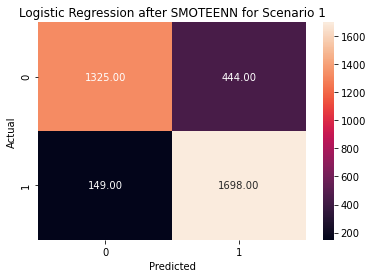

In [161]:
sns.heatmap(logreg_smote_a, annot=True, fmt='.2f')
plt.title('Logistic Regression after SMOTEENN for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()